Stuff cut from data_prep_georgi.ipynb

# Dataset random exploration (use with thumb images only)

In [14]:
rand_idx = random.randint(0, len(ds))
meta, image, json_idx, idx, twin_id = ds[rand_idx]
print(rand_idx)
print(meta['name'])
print(twin_id)

7621
R_07_00861_1e48cb.JPG
38010


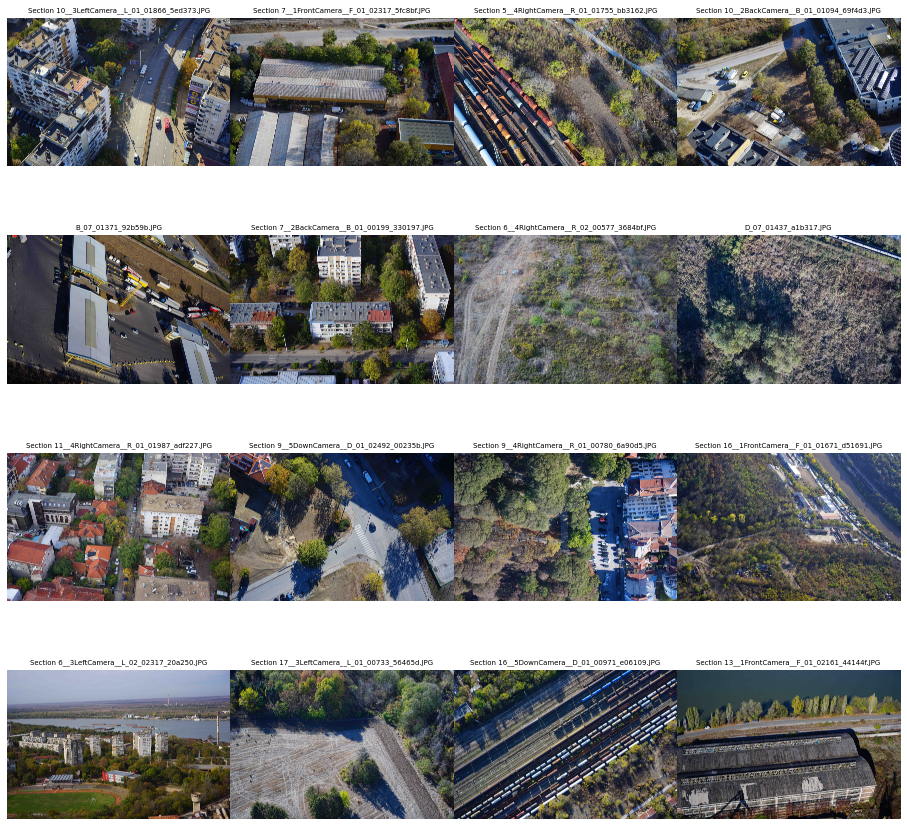

In [13]:
# Select 16 random indices
rand_indices = [random.randint(0, len(ds)) for _ in range(16)]

# Create a 4x4 grid to display the images
fig, axes = plt.subplots(4, 4, figsize=(16, 16))  # Adjusted the figure size for a tighter layout

# Loop over the 16 random indices
for i, ax in enumerate(axes.flat):
    # Get random sample from the dataset
    rand_idx = rand_indices[i]
    meta, image, json_idx, idx, twin_id = ds[rand_idx]
    
    # Display image in the grid
    ax.imshow(Image.fromarray(image))
    ax.set_title(meta['name'],fontsize=7)
    ax.axis('off')  # Hide the axes for a cleaner look

# Adjust layout to remove spacing between images
plt.subplots_adjust(wspace=0, hspace=0)

# Show the grid
plt.show()

# Locations viz

In [162]:
# Coordinates in the drone images are in ECEF coordinates, we convert them to lat, long, altitude with this function
transformer = Transformer.from_crs("epsg:4978", "epsg:4326", always_xy=True)
def ecef_to_lla(x, y, z):
    return list(transformer.transform(x, y, z))

In [208]:
positions = []
for entry_idx in tqdm(range(len(ds))):
    meta = ds.get_meta(entry_idx)
    lat, long, altitude = ecef_to_lla(*meta['position'])
    positions.append((lat, long))

100%|███████████████████████████████| 181663/181663 [00:00<00:00, 371051.70it/s]


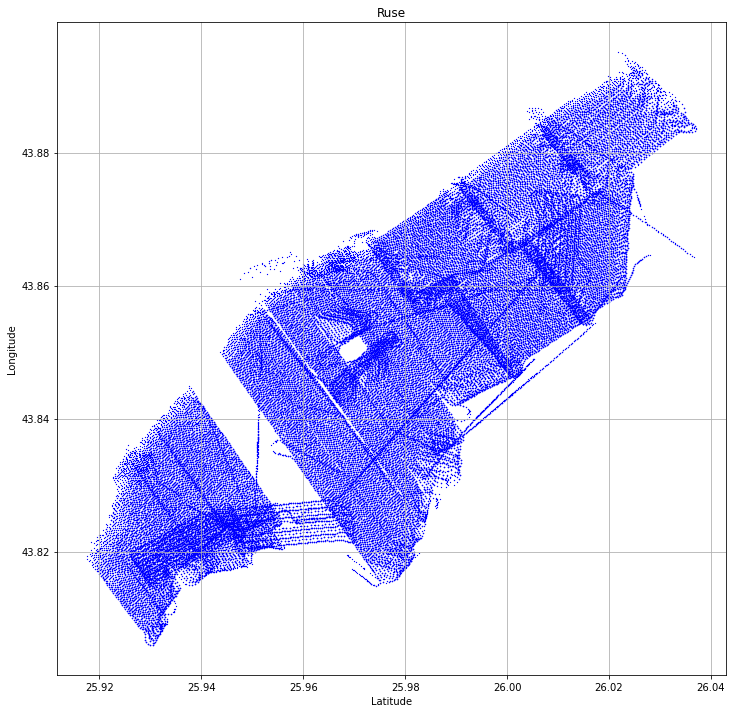

In [209]:
# Extract the x and y coordinates from the list of tuples
x_coords, y_coords = zip(*positions)

# Create a scatter plot
plt.figure(figsize=(12,12))
plt.scatter(x_coords, y_coords, c='blue', s=0.1, marker='x')

# Adding titles and labels
plt.title('Ruse')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Show the plot
plt.grid(True)
plt.show()

# Direction filtering

In [212]:
def get_camera_direction(meta):
    # Extract the rotation matrix and reshape it to 3x3
    rotation_matrix = np.array(meta['rotation']).reshape(3, 3)
    
    # Define the camera's local forward direction vector
    camera_forward = np.array([0, 0, -1])
    
    # Calculate the direction vector in world coordinates
    direction_world = np.dot(rotation_matrix, camera_forward)
    
    # Normalize the direction vector
    direction_world_normalized = direction_world / np.linalg.norm(direction_world)
    
    return direction_world_normalized

In [213]:
get_camera_direction(ds[100][0])

array([-0.54153194,  0.22371476,  0.81036712])

# CocoDetector

# V I have no idea where those cells came from V

In [4]:
%load_ext autoreload
%autoreload 2
import sys
import inject
sys.path.append('/home/suzunov/projects/scene-understanding/')
from scene_understanding.object_detectors.coco.coco_object_detector import CocoObjectDetector
from dotenv import load_dotenv
from scene_understanding.util.di_config import di_config

load_dotenv("env.txt")
inject.configure(di_config)

detector = CocoObjectDetector()

InjectorException: Injector is already configured

In [ ]:
test_img = ds[86204][1]
Image.fromarray(test_img)

In [ ]:
detections = detector.detect(test_img, class_names=['car'])

In [ ]:
detections

In [ ]:
bboxes = [d.bounding_box for d in detections]

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_bounding_boxes(test_img, bboxes):
    """
    Visualizes bounding boxes with percentage coordinates on an image using matplotlib.
    
    Parameters:
    test_img (ndarray): The image on which to draw the bounding boxes.
    bboxes (list): A list of bounding boxes, where each bounding box is a tuple (x_start, y_start, x_end, y_end) in percentage.
    """
    fig, ax = plt.subplots(1)
    ax.imshow(test_img)
    
    img_height, img_width = test_img.shape[:2]
    
    # Draw each bounding box
    for bbox in bboxes:
        x_start_perc, y_start_perc, x_end_perc, y_end_perc = bbox
        x_start = x_start_perc * img_width
        y_start = y_start_perc * img_height
        x_end = x_end_perc * img_width
        y_end = y_end_perc * img_height
        width = x_end - x_start
        height = y_end - y_start
        
        rect = patches.Rectangle((x_start, y_start), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.axis('off')  # Turn off axis lines and labels
    plt.show()


In [ ]:
from ultralytics import YOLO

In [ ]:
def detect_cars(img):
    # Load the pre-trained YOLOv5 model from Ultralytics
    model = YOLO('yolov5s')  # Use 'yolov5m', 'yolov5l', or 'yolov5x' for larger models if desire
    # Perform inference
    results = model(img)

    # List to store bounding boxes
    car_bboxes = []

    # Filter results for 'car' label
    for result in results.pred[0]:
        class_id = int(result[-1])
        label = results.names[class_id]

        if label == 'car':
            x1, y1, x2, y2 = map(int, result[:4])  # Get bounding box coordinates
            car_bboxes.append((x1, y1, x2, y2))  # Append bounding box to list

    return car_bboxes

# Example usage:
bboxes = detect_cars('path/to/your/aerial_image.jpg')

In [ ]:
import matplotlib.patches as patches

In [ ]:
visualize_bounding_boxes(test_img, bboxes)

In [ ]:
test_img.shape